In [1]:
%pip install pandas scikit-learn numpy matplotlib seaborn missingno

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.sparse import hstack
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

In [3]:
df = pd.read_csv('amazon_products.csv', encoding='ISO-8859-1', on_bad_lines='skip')

print(df.head(10))

                                               title     price rating  \
0  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
1  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
2  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
3  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
4  Alarm Clock,Table Lamp with Wireless Charging,...   $41.99     4.2   
5  Netzu Wooden Alarm Clock, Loud Digital Plug-in...   $15.99     4.4   
6  Sound Machine Alarm Clock for Bedroom: Dimmabl...   $22.79     4.5   
7  Alarm Clock for Bedroom, 2 Alarms Loud LED Big...   $12.99     4.3   
8  DreamSky Wooden Digital Alarm Clocks for Bedro...  $169.99     4.6   
9  Cadmos Super Loud Alarm Clock for Heavy Sleepe...   $14.99     4.2   

  sold_quantity  
0          20K+  
1          10K+  
2          20K+  
3          10K+  
4           NaN  
5          400+  
6          100+  
7           6K+  
8           5K+  
9           2K+ 

In [4]:
df.shape

(11186, 4)

In [5]:
df.dtypes

title            object
price            object
rating           object
sold_quantity    object
dtype: object

In [6]:
df.isna().sum()

title               0
price               0
rating            746
sold_quantity    3530
dtype: int64

Axes(0.125,0.11;0.775x0.77)


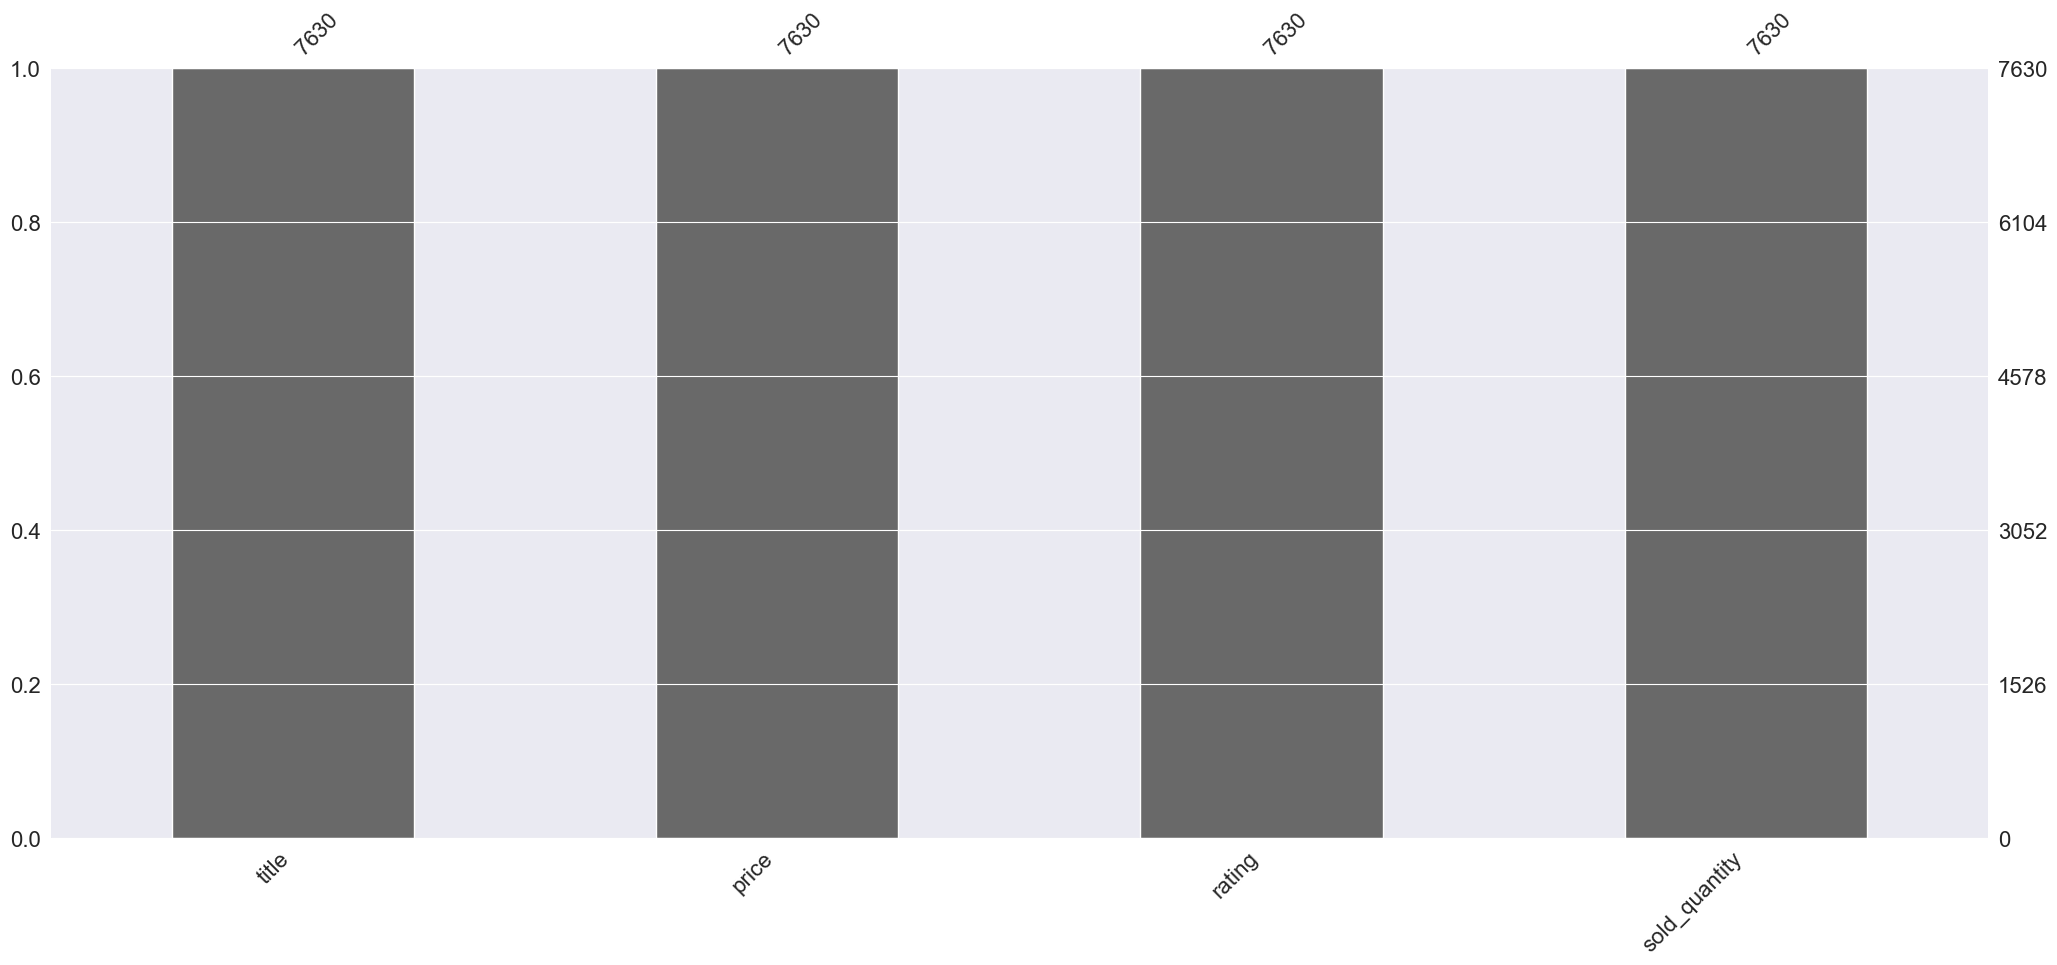

In [99]:
print(ms.bar(df))

In [7]:
def parse_price(value):
    if isinstance(value, str):
        value = re.sub(r'[^0-9KMkm\.]', '', value).upper()
        try:
            if 'K' in value:
                return float(value.replace('K', '')) * 1000
            elif 'M' in value:
                return float(value.replace('M', '')) * 1_000_000
            else:
                return float(value)
        except ValueError:
            return None
    return value

In [8]:
df['price'] = df['price'].apply(parse_price)
df['sold_quantity'] = df['sold_quantity'].apply(parse_price)
print(df['sold_quantity'].head(10))

0    20000.0
1    10000.0
2    20000.0
3    10000.0
4        NaN
5      400.0
6      100.0
7     6000.0
8     5000.0
9     2000.0
Name: sold_quantity, dtype: float64


In [9]:
# Drop rows with missing price or rating
df = df.dropna(subset=['price', 'rating','sold_quantity'])

In [10]:
#TfidfVectorizer to convert product title into numeric TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=100, min_df=2)
title_tfidf = vectorizer.fit_transform(df['title'])

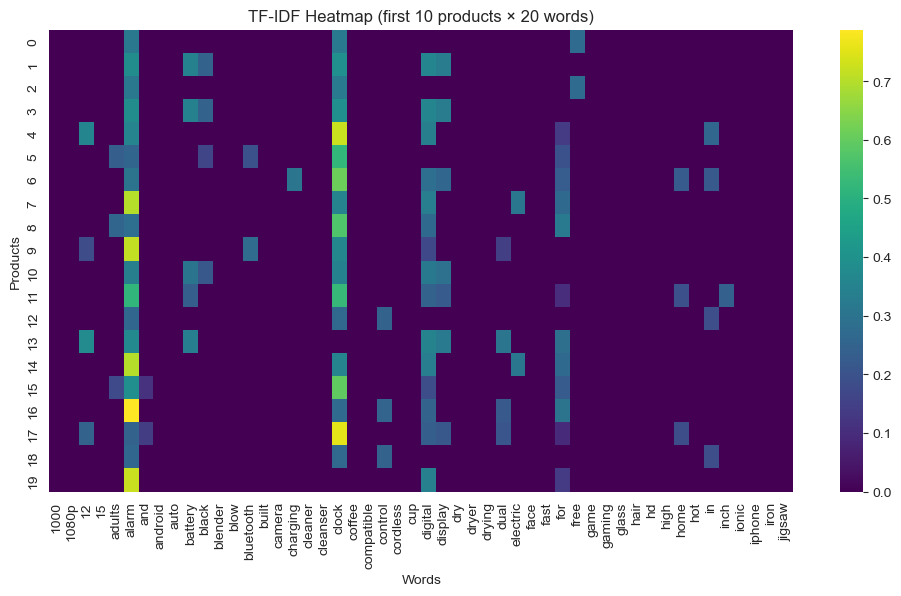

In [11]:
# Get the feature names
features = vectorizer.get_feature_names_out()

# Convert sparse matrix to DataFrame
tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=features)

sample = tfidf_df.iloc[:20, :50]

plt.figure(figsize=(12,6))
sns.heatmap(sample, cmap="viridis", xticklabels=sample.columns, yticklabels=sample.index)
plt.title("TF-IDF Heatmap (first 10 products × 20 words)")
plt.xlabel("Words")
plt.ylabel("Products")
plt.show()

In [12]:
#Standardize rating and sold_quantity
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[['rating', 'sold_quantity']])

# Combine features
X = hstack([title_tfidf, numeric_scaled])
y = df['price']

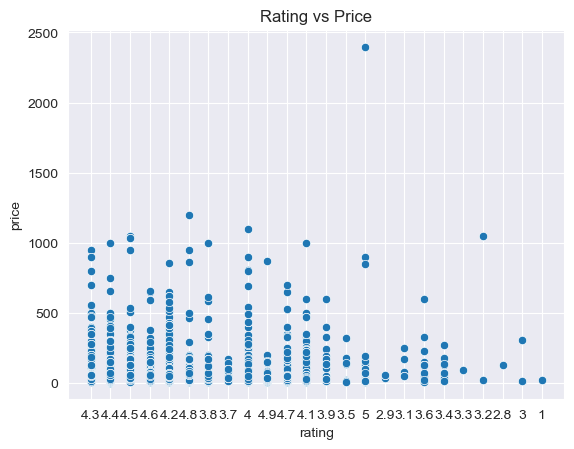

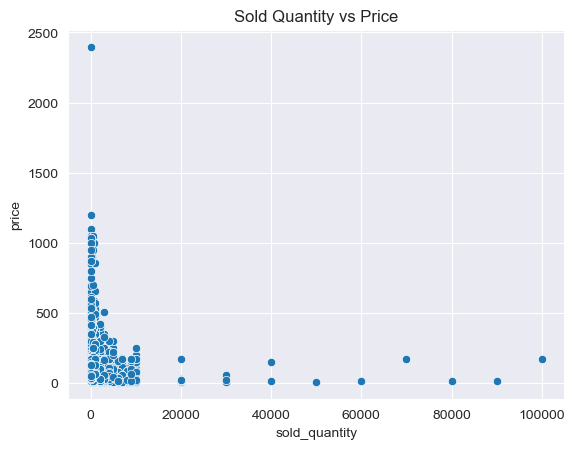

In [13]:
sns.scatterplot(data=df, x='rating', y='price')
plt.title("Rating vs Price")
plt.show()

sns.scatterplot(data=df, x='sold_quantity', y='price')
plt.title("Sold Quantity vs Price")
plt.show()

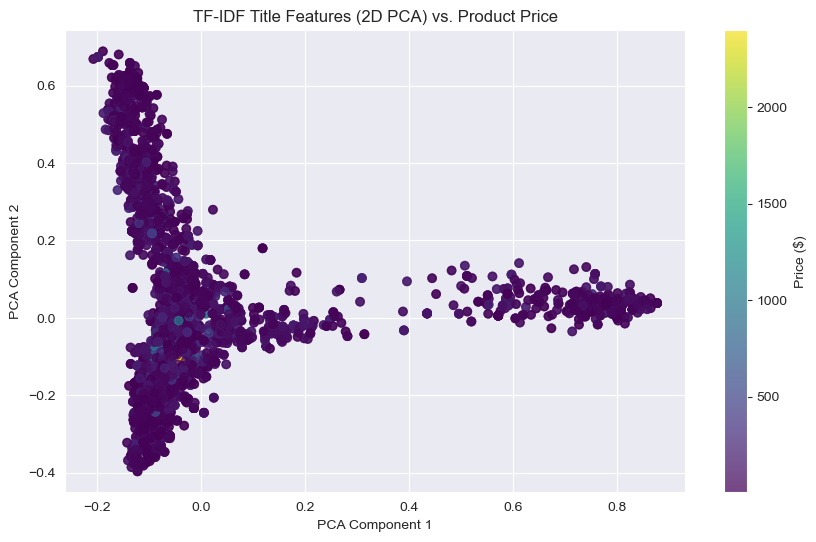

In [14]:
# Reduce TF-IDF title features to 2D for plotting
pca = PCA(n_components=2)
title_pca = pca.fit_transform(title_tfidf.toarray())

# Create a DataFrame with PCA components and price
title_price_df = pd.DataFrame({
    'PCA1': title_pca[:, 0],
    'PCA2': title_pca[:, 1],
    'Price': df['price']
})

# Plot PCA components colored by price
plt.figure(figsize=(10, 6))
scatter = plt.scatter(title_price_df['PCA1'], title_price_df['PCA2'],
                      c=title_price_df['Price'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Price ($)')
plt.title('TF-IDF Title Features (2D PCA) vs. Product Price')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [15]:
#split For train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Linear Regression Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [17]:
# Random ForestRegressor Model Training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [18]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name}")
    print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print(f"Model Accuracy: {round(r2_score(y_true, y_pred), 3) * 100:.2f}%")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest Regressor", y_test, y_pred_rf)


 Linear Regression
MAE : 58.63
RMSE: 95.71
Model Accuracy: 31.70%

 Random Forest Regressor
MAE : 14.69
RMSE: 35.55
Model Accuracy: 90.60%


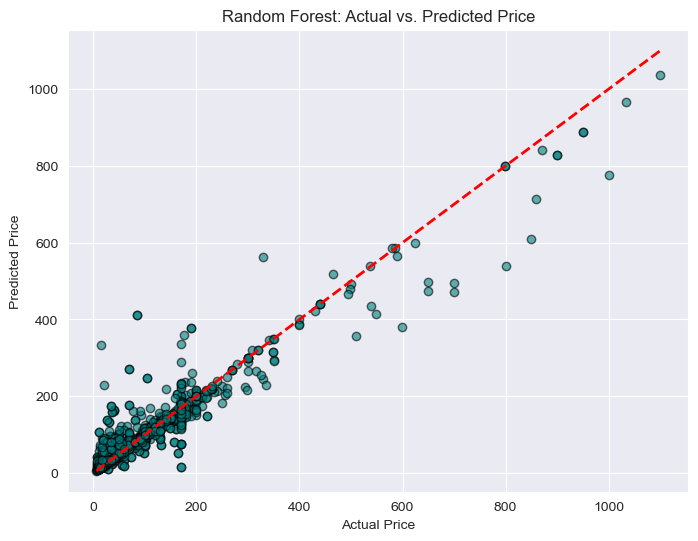

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='teal', edgecolors='k')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs. Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect line
plt.grid(True)
plt.show()

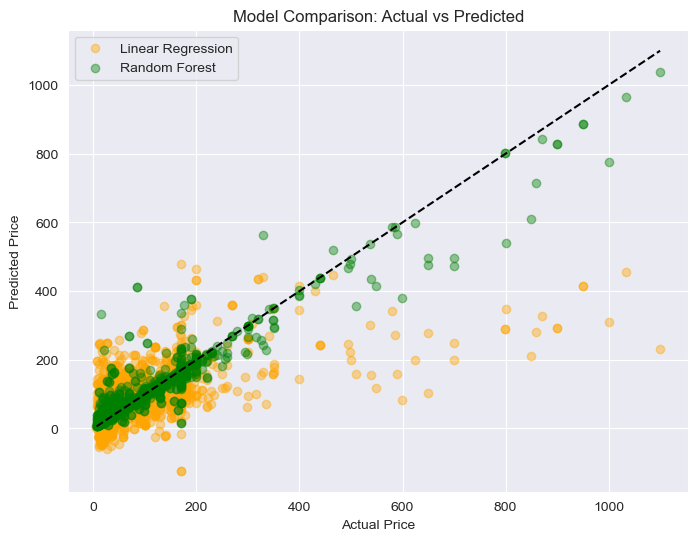

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.4, label="Linear Regression", color='orange')
plt.scatter(y_test, y_pred_rf, alpha=0.4, label="Random Forest", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Model Comparison: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Predict on New User Input
def estimate_price(title, rating, sold_quantity):
    title_vec = vectorizer.transform([title])

    # Use DataFrame with correct feature names for scaler
    numeric_input_df = pd.DataFrame([[rating, sold_quantity]], columns=['rating', 'sold_quantity'])
    numeric_input_scaled = scaler.transform(numeric_input_df)

    # Combine title + numeric
    features = hstack([title_vec, numeric_input_scaled])
    prediction = rf.predict(features)[0]
    return round(prediction, 2)

# Example Usage
user_input = {
    "title": "SteelSeries Arctis Nova 1 Wired Multi-System Gaming Headset for PC with 3.5mm Jack, Black",
    "rating": 4.1,
    "sold_quantity": 300
}

estimated_price = estimate_price(user_input['title'], user_input['rating'], user_input['sold_quantity'])
print(f"\n💰 Estimated Price for \"{user_input['title']}\": ${estimated_price}")


💰 Estimated Price for "SteelSeries Arctis Nova 1 Wired Multi-System Gaming Headset for PC with 3.5mm Jack, Black": $76.13
